# Exploring MovieLens

Three part:
- clustering

## The data

In [1]:
import pandas as pd

In [2]:
ratings = pd.read_csv('data/ml-100k/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


We are not going to use timestamp for now

In [12]:
ratings = ratings.drop(['timestamp'], axis=1)

In [14]:
ratings.columns

Index(['userId', 'movieId', 'rating'], dtype='object')

In [3]:
movies = pd.read_csv('data/ml-100k/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
tags = pd.read_csv('data/ml-100k/tags.csv')
tags.head()

,userId,movieId,tag,timestamp
0,15,339,sandra 'boring' bullock,1138537770
1,15,1955,dentist,1193435061
2,15,7478,Cambodia,1170560997
3,15,32892,Russian,1170626366
4,15,34162,forgettable,1141391765


In [5]:
links = pd.read_csv('data/ml-100k/links.csv')
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


What do you think?
- ratings data: 
 - I can cluster users based on how they rate movies
 - I can cluster movies based on how they rated by users
- movies data:
 - I can custer movies based on genres characteristic (since most movies has more that one genres). It is very useful

### The ratings

In [15]:
len(ratings['userId'].unique()), len(ratings['movieId'].unique()), len(ratings['rating'].unique())

(671, 9066, 10)

Making pivot table, There can be two modes I think that can be usefull to study

1. The first can be usefull to cluster the users:
 - users: userId
 - columns: movieId
 - value: rating
    
- The second can be usefull to cluster the movies
 - rows: movieId
 - columns: userId
 - value: rating

I always forget to do pivot table in Python, here we go the docs:

# User clustring
steps:
1. making pivot table, here we use The FTrst
2. dimensional reduction, can be 2 ways:
 - using PCA to reduce dim to 50, then use t-SNE to futher reduce from 50 to 2
 - directly using t-SNE
3. use clustering algo to cluster the users
4. interpret the clusters of users

In [24]:
ratings_pvt = pd.pivot_table(ratings, values='rating', index='userId', columns='movieId', fill_value=0)
ratings_pvt.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,4.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,4.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0,0,0.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0


In [25]:
ratings_pvt.values.shape

(671, 9066)

## Dimensionality Reduction

### PCA

In [31]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

%matplotlib inline

In [27]:
ratings_pvt_values = ratings_pvt.values

In [38]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(ratings_pvt_values)

In [39]:
X_pca.shape

(671, 2)

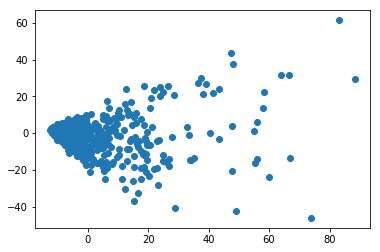

In [40]:
plt.scatter(X_pca[:,0], X_pca[:,1])

## t-SNE

how to set up a t-sne? Here's some reference to read:

In [94]:
from sklearn.manifold import TSNE

In [95]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(ratings_pvt_values)

In [96]:
X_tsne.shape

(671, 2)

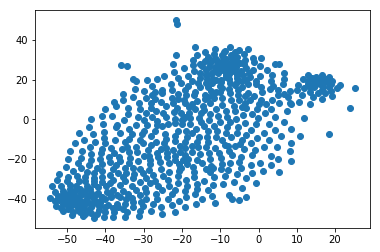

In [97]:
plt.scatter(X_tsne[:,0], X_tsne[:,1])

In [66]:
tsne_p50 = TSNE(n_components=2, perplexity=50)
X_tsne_p50 = tsne_p50.fit_transform(ratings_pvt_values)

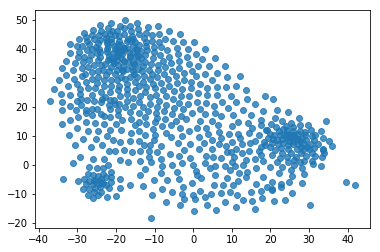

In [67]:
plt.scatter(X_tsne_p50[:,0], X_tsne_p50[:,1], alpha=0.8)

What the hell?

In [58]:
pca_50 = PCA(n_components=50)
X_pca_50 = pca_50.fit_transform(ratings_pvt_values)

In [59]:
X_pca_50.shape

(671, 50)

In [63]:
X_tsne_p50_pca = tsne_p50.fit_transform(X_pca_50)

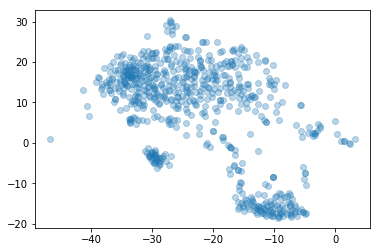

In [65]:
plt.scatter(X_tsne_p50_pca[:,0], X_tsne_p50_pca[:,1], alpha=0.3)

## Unsupervised Clustering

Let's see both:
- X_tsne_p50
- X_tsne_p50_pca

### Gaussian Mixture

In [73]:
from sklearn.mixture import GaussianMixture

#### X_tsne_p50

In [88]:
gm_p50 = GaussianMixture(3)
gm_p50.fit(X_tsne_p50)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [89]:
cluster_label_p50 = gm_p50.predict(X_tsne_p50)

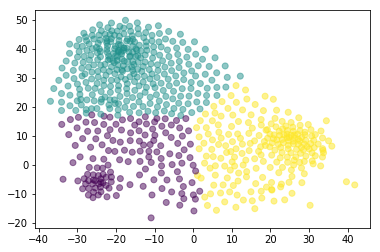

In [90]:
plt.scatter(X_tsne_p50[:, 0], X_tsne_p50[:, 1], c=cluster_label_p50, alpha=0.5)

#### X_tsne_p50_pca

In [91]:
gm_p50_pca = GaussianMixture(4)
gm_p50_pca.fit(X_tsne_p50_pca)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=4, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [92]:
cluster_label_p50_pca = gm_p50_pca.predict(X_tsne_p50_pca)

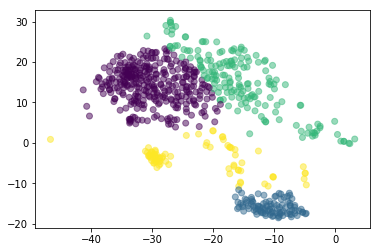

In [93]:
plt.scatter(X_tsne_p50_pca[:, 0], X_tsne_p50_pca[:, 1], c=cluster_label_p50_pca, alpha=0.5)

I don't know what is better way to cluster this

## Interpret the cluster

From the available data, what is the characteristic of user that we can used?
- the data is about the users rate the movies. But it is bad to just see the characteristic of user based on movie id. you know what i mean.
- the movies has genre characteristic. So it might be good to see the characteristic of user based on the genre